In [2]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 读取数据集
file_path = 'dataset/NBA_Season_Stats.csv'  # 请将路径替换为你的本地文件路径
nba_data = pd.read_csv(file_path)

# 数据清理：去除无关列并处理缺失值
nba_data_cleaned = nba_data.drop(columns=['Player', 'Tm', 'Year'])
nba_data_cleaned = nba_data_cleaned.dropna()

# 特征工程：创建PTS_per_min特征
nba_data_cleaned['PTS_per_min'] = nba_data_cleaned['PTS'] / nba_data_cleaned['MP']

# 选择用于聚类的特征（根据重要性排名）
selected_features = ['AST', 'TRB', 'MP', 'DRB', 'ORB', 'STL', 'BLK', 'FG%', 'eFG%', 'PF', 'TOV', 'PTS', '2P%', 'G', 'PTS_per_min', '3P%', 'Age', 'FT%']

# 标准化特征数据
scaler = StandardScaler()
nba_data_standardized = scaler.fit_transform(nba_data_cleaned[selected_features])

# 将标准化的数据转换为DataFrame格式
nba_data_standardized_df = pd.DataFrame(nba_data_standardized, columns=selected_features)

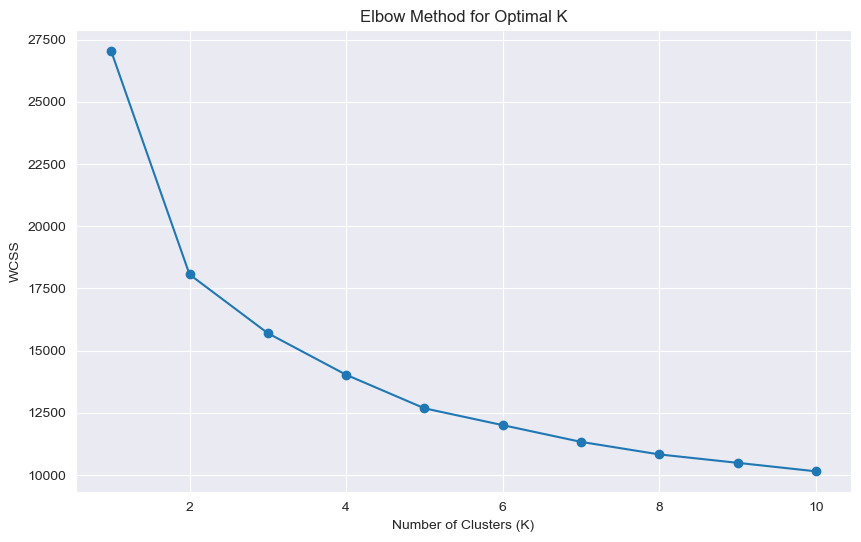

In [3]:
# 使用肘部法则确定最佳K值
# 取样数据以加快计算速度
sampled_data = nba_data_standardized_df.sample(frac=0.1, random_state=42)

# 使用肘部法则计算不同K值的WCSS（簇内误差平方和）
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(sampled_data)
    wcss.append(kmeans.inertia_)

# 绘制肘部法则图
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()

In [3]:
# 使用最佳K值进行KMeans聚类
# 肘部法则图表显示，当簇的数量为4时，WCSS的下降幅度明显减小。因此，我们选择K=4进行KMeans聚类。
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
nba_data_cleaned['Cluster'] = kmeans.fit_predict(nba_data_standardized)

In [4]:
# 分析聚类结果
cluster_analysis = nba_data_cleaned.groupby('Cluster')[selected_features].mean()
print(cluster_analysis)

                AST         TRB           MP         DRB         ORB  \
Cluster                                                                
0        135.080732  235.672551  1530.170075  168.305059   67.367492   
1         28.369896   41.194207   293.207028   29.502374   11.691833   
2        379.977283  313.862309  2560.544274  234.756143   79.106166   
3         49.945772   80.963211   556.666507   57.830865   23.132346   
4        152.638783  627.113525  2376.312330  430.402499  196.711027   

                STL        BLK       FG%      eFG%          PF         TOV  \
Cluster                                                                      
0         50.413994  24.399785  0.449311  0.483379  145.057912   86.057481   
1         10.295347   3.917854  0.333151  0.362412   31.258784   18.129630   
2        105.660176  25.034307  0.458536  0.493124  185.787204  184.055633   
3         18.069517   7.926660  0.445967  0.484131   55.472527   32.705925   
4         67.734383  90.725

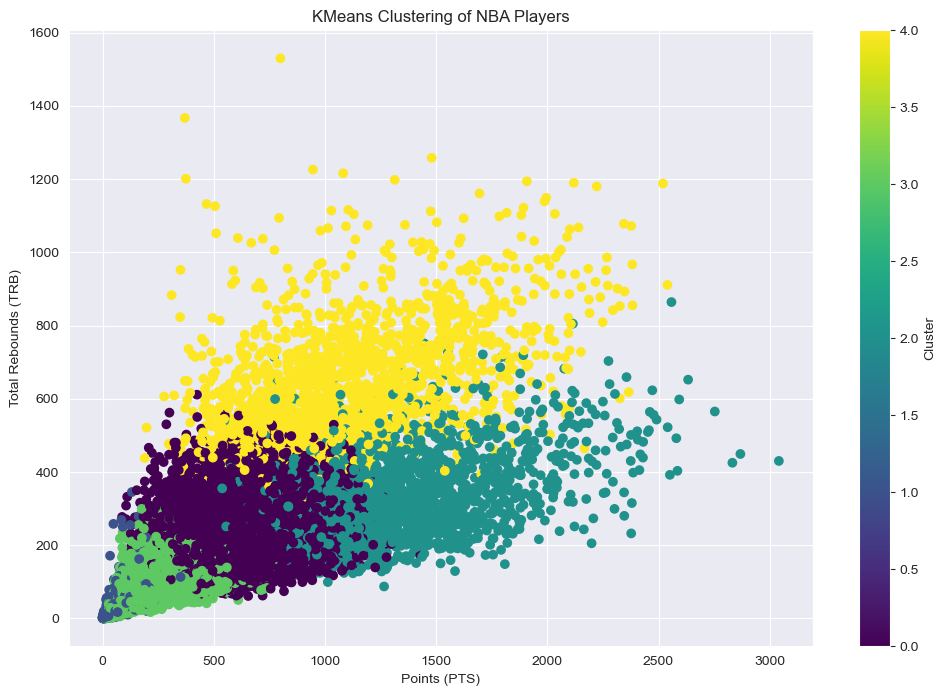

In [5]:
# 可视化聚类结果
plt.figure(figsize=(12, 8))
plt.scatter(nba_data_cleaned['PTS'], nba_data_cleaned['TRB'], c=nba_data_cleaned['Cluster'], cmap='viridis', marker='o')
plt.title('KMeans Clustering of NBA Players')
plt.xlabel('Points (PTS)')
plt.ylabel('Total Rebounds (TRB)')
plt.colorbar(label='Cluster')
plt.show()

In [6]:
# 计算聚类评估指标
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# 计算轮廓系数
silhouette_avg = silhouette_score(nba_data_standardized, nba_data_cleaned['Cluster'])
print(f'Silhouette Coefficient: {silhouette_avg:.3f}')

# 计算Calinski-Harabasz Index
calinski_harabasz_avg = calinski_harabasz_score(nba_data_standardized, nba_data_cleaned['Cluster'])
print(f'Calinski-Harabasz Index: {calinski_harabasz_avg:.3f}')

# 计算Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(nba_data_standardized, nba_data_cleaned['Cluster'])
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.3f}')

Silhouette Coefficient: 0.160
Calinski-Harabasz Index: 4169.260
Davies-Bouldin Index: 1.655


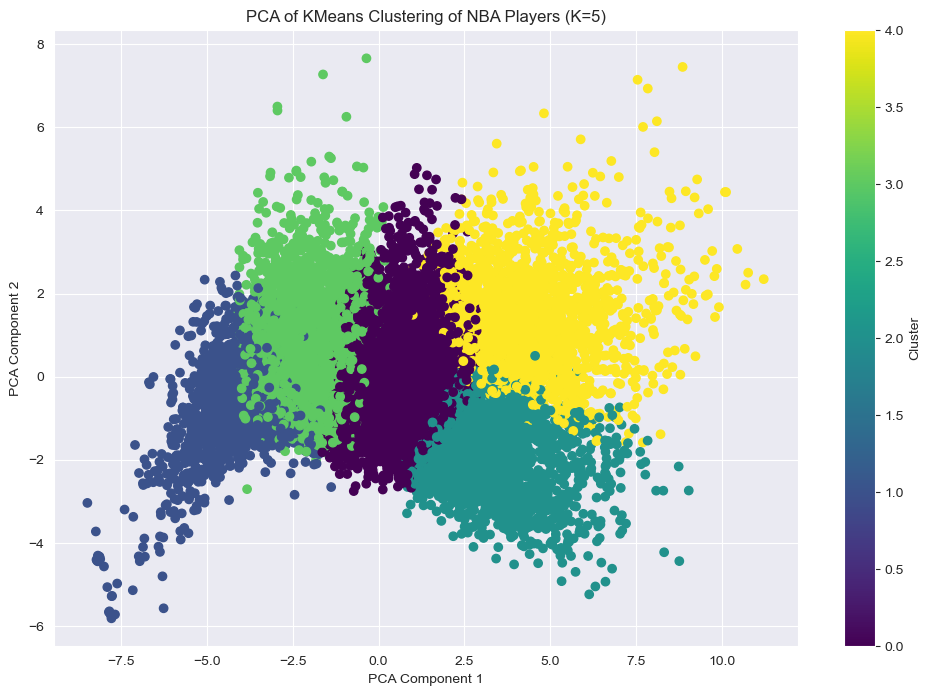

In [7]:
# 使用PCA降维可视化聚类结果
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(nba_data_standardized)

# 将PCA结果添加到数据集中
nba_data_cleaned['PCA1'] = pca_result[:, 0]
nba_data_cleaned['PCA2'] = pca_result[:, 1]

# 可视化PCA降维后的聚类结果
plt.figure(figsize=(12, 8))
plt.scatter(nba_data_cleaned['PCA1'], nba_data_cleaned['PCA2'], c=nba_data_cleaned['Cluster'], cmap='viridis', marker='o')
plt.title('PCA of KMeans Clustering of NBA Players (K=5)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [8]:
# 尝试不同的K值来评估聚类效果
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(nba_data_standardized)

    silhouette_avg = silhouette_score(nba_data_standardized, clusters)
    calinski_harabasz_avg = calinski_harabasz_score(nba_data_standardized, clusters)
    davies_bouldin_avg = davies_bouldin_score(nba_data_standardized, clusters)

    print(f'K = {k}')
    print(f'  Silhouette Coefficient: {silhouette_avg:.3f}')
    print(f'  Calinski-Harabasz Index: {calinski_harabasz_avg:.3f}')
    print(f'  Davies-Bouldin Index: {davies_bouldin_avg:.3f}')

K = 2
  Silhouette Coefficient: 0.290
  Calinski-Harabasz Index: 7590.332
  Davies-Bouldin Index: 1.310
K = 3
  Silhouette Coefficient: 0.187
  Calinski-Harabasz Index: 5454.348
  Davies-Bouldin Index: 1.623
K = 4
  Silhouette Coefficient: 0.176
  Calinski-Harabasz Index: 4650.746
  Davies-Bouldin Index: 1.662
K = 5
  Silhouette Coefficient: 0.160
  Calinski-Harabasz Index: 4169.260
  Davies-Bouldin Index: 1.655
K = 6
  Silhouette Coefficient: 0.153
  Calinski-Harabasz Index: 3704.683
  Davies-Bouldin Index: 1.668
K = 7
  Silhouette Coefficient: 0.141
  Calinski-Harabasz Index: 3344.727
  Davies-Bouldin Index: 1.785
K = 8
  Silhouette Coefficient: 0.128
  Calinski-Harabasz Index: 3045.962
  Davies-Bouldin Index: 1.767
K = 9
  Silhouette Coefficient: 0.124
  Calinski-Harabasz Index: 2822.867
  Davies-Bouldin Index: 1.771
K = 10
  Silhouette Coefficient: 0.119
  Calinski-Harabasz Index: 2610.916
  Davies-Bouldin Index: 1.816


In [8]:
# 根据评价指标选择最佳K值, 使用 k = 2 进行聚类
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
nba_data_cleaned['Cluster'] = kmeans.fit_predict(nba_data_standardized)

# 分析聚类结果
cluster_analysis = nba_data_cleaned.groupby('Cluster')[selected_features].mean()
print(cluster_analysis)

                AST         TRB           MP         DRB         ORB  \
Cluster                                                                
0        225.574167  387.720980  2188.886049  275.167199  112.553781   
1         61.491270   96.076656   665.591605   68.889620   27.187037   

               STL        BLK       FG%      eFG%          PF         TOV  \
Cluster                                                                     
0        75.953902  45.031949  0.471410  0.497301  189.817891  141.672296   
1        22.106793   9.543052  0.414895  0.450110   65.825520   38.558359   

                PTS       2P%          G  PTS_per_min       3P%        Age  \
Cluster                                                                      
0        994.629089  0.489744  74.258634     0.444695  0.247976  26.801156   
1        235.642789  0.440510  40.054413     0.350076  0.250014  26.839632   

              FT%  
Cluster            
0        0.758880  
1        0.726798  


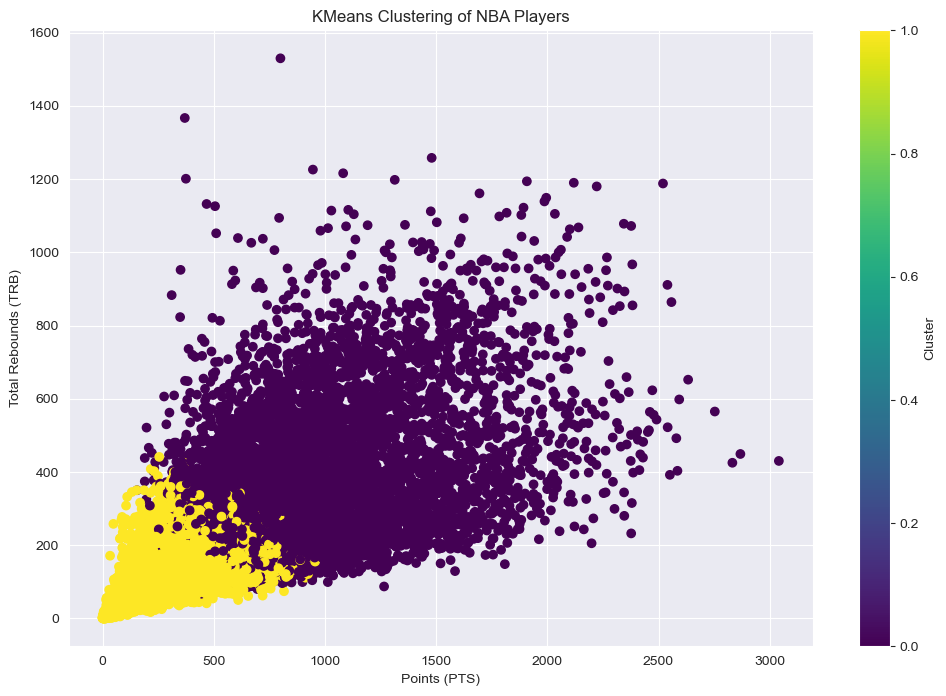

In [9]:
# 可视化聚类结果
plt.figure(figsize=(12, 8))
plt.scatter(nba_data_cleaned['PTS'], nba_data_cleaned['TRB'], c=nba_data_cleaned['Cluster'], cmap='viridis', marker='o')
plt.title('KMeans Clustering of NBA Players')
plt.xlabel('Points (PTS)')
plt.ylabel('Total Rebounds (TRB)')
plt.colorbar(label='Cluster')
plt.show()

In [10]:
# 计算评价指标
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

silhouette_avg = silhouette_score(nba_data_standardized, nba_data_cleaned['Cluster'])
calinski_harabasz_avg = calinski_harabasz_score(nba_data_standardized, nba_data_cleaned['Cluster'])
davies_bouldin_avg = davies_bouldin_score(nba_data_standardized, nba_data_cleaned['Cluster'])

print(f'Silhouette Coefficient: {silhouette_avg:.3f}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_avg:.3f}')
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.3f}')

Silhouette Coefficient: 0.290
Calinski-Harabasz Index: 7590.332
Davies-Bouldin Index: 1.310


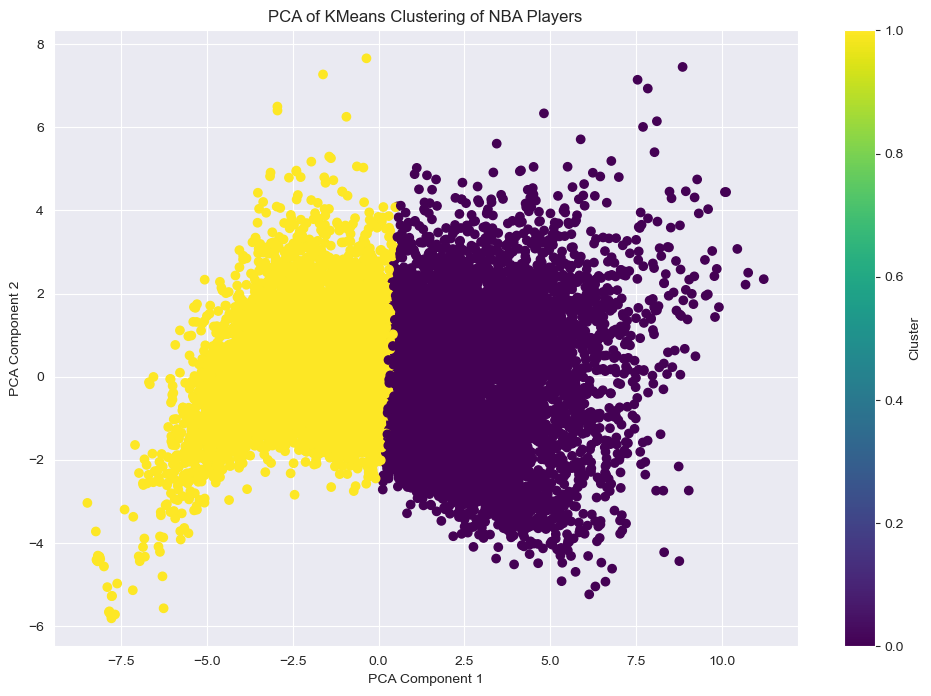

In [11]:
# 使用PCA降维可视化聚类结果
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(nba_data_standardized)

# 将PCA结果添加到数据集中
nba_data_cleaned['PCA1'] = pca_result[:, 0]
nba_data_cleaned['PCA2'] = pca_result[:, 1]

# 可视化PCA降维后的聚类结果
plt.figure(figsize=(12, 8))
plt.scatter(nba_data_cleaned['PCA1'], nba_data_cleaned['PCA2'], c=nba_data_cleaned['Cluster'], cmap='viridis', marker='o')
plt.title('PCA of KMeans Clustering of NBA Players')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

Accuracy: 0.665476
Classification Report:
              precision    recall  f1-score   support

           C       0.69      0.57      0.63       584
          PF       0.59      0.62      0.61       879
          PG       0.82      0.87      0.84      1056
          SF       0.61      0.57      0.59       977
          SG       0.60      0.63      0.62       985

    accuracy                           0.67      4481
   macro avg       0.66      0.65      0.66      4481
weighted avg       0.66      0.67      0.66      4481



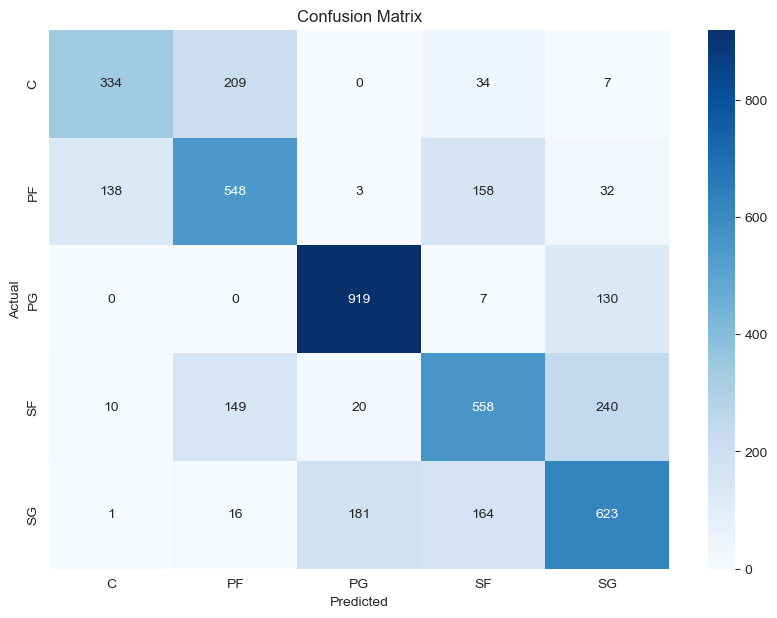

In [12]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 读取数据集
file_path = 'dataset/NBA_Season_Stats.csv'  # 请将路径替换为你的本地文件路径
nba_data = pd.read_csv(file_path)

# 数据清理：去除无关列并处理缺失值
nba_data_cleaned = nba_data.drop(columns=['Player', 'Tm', 'Year'])
nba_data_cleaned = nba_data_cleaned.dropna()

# 特征工程：创建PTS_per_min特征
nba_data_cleaned['PTS_per_min'] = nba_data_cleaned['PTS'] / nba_data_cleaned['MP']

# 选择用于训练的特征（根据重要性排名）
selected_features = ['AST', 'TRB', 'MP', 'DRB', 'ORB', 'STL', 'BLK', 'FG%', 'eFG%', 'PF', 'TOV', 'PTS', '2P%', 'G', 'PTS_per_min', '3P%', 'Age', 'FT%']

# 标准化特征数据
scaler = StandardScaler()
nba_data_standardized = scaler.fit_transform(nba_data_cleaned[selected_features])

# 使用KMeans聚类
optimal_k = 5  # 根据之前的评价指标选择最佳K值
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
nba_data_cleaned['Cluster'] = kmeans.fit_predict(nba_data_standardized)

# 将位置标签转换为数值标签
label_encoder = LabelEncoder()
nba_data_cleaned['Pos_Label'] = label_encoder.fit_transform(nba_data_cleaned['Pos'])

# 准备训练和测试数据，包括KMeans聚类结果特征
X = nba_data_cleaned[selected_features + ['Cluster']]
y = nba_data_cleaned['Pos_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 训练分类模型（随机森林分类器）
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# 预测并评估模型
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy:.6f}')
print('Classification Report:')
print(classification_rep)

# 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.633743
Classification Report:
              precision    recall  f1-score   support

           C       0.63      0.68      0.66      1078
          PF       0.52      0.51      0.52      1133
          PG       0.81      0.86      0.84      1155
          SF       0.57      0.53      0.55      1145
          SG       0.61      0.58      0.60      1108

    accuracy                           0.63      5619
   macro avg       0.63      0.63      0.63      5619
weighted avg       0.63      0.63      0.63      5619



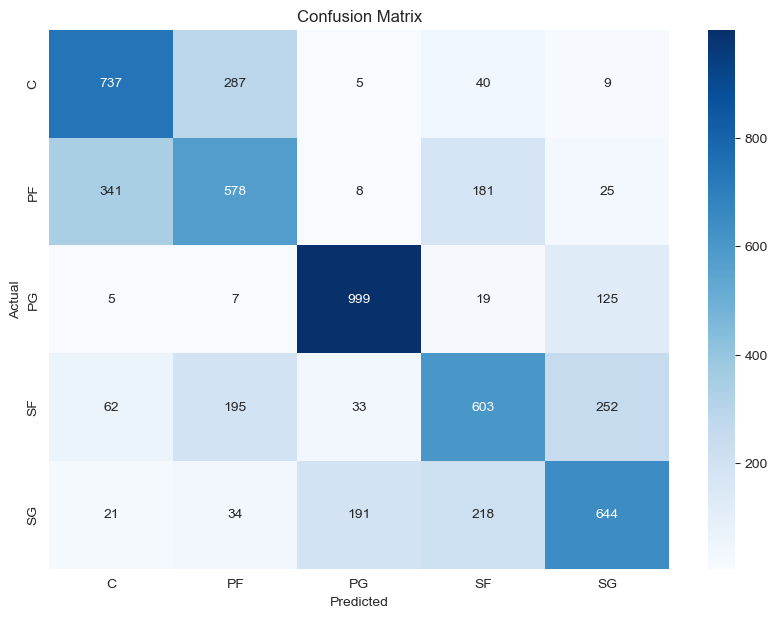

In [13]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 读取数据集
file_path = 'dataset/NBA_Season_Stats.csv'  # 请将路径替换为你的本地文件路径
nba_data = pd.read_csv(file_path)

# 数据清理：去除无关列并使用0填补缺失值
nba_data_cleaned = nba_data.drop(columns=['Player', 'Tm', 'Year'])
nba_data_cleaned = nba_data_cleaned.fillna(0)

# 特征工程：创建PTS_per_min特征
nba_data_cleaned['PTS_per_min'] = nba_data_cleaned['PTS'] / nba_data_cleaned['MP']

# 选择用于训练的特征（根据重要性排名）
selected_features = ['AST', 'TRB', 'MP', 'DRB', 'ORB', 'STL', 'BLK', 'FG%', 'eFG%', 'PF', 'TOV', 'PTS', '2P%', 'G', 'PTS_per_min', '3P%', 'Age', 'FT%']

# 标准化特征数据
scaler = StandardScaler()
nba_data_standardized = scaler.fit_transform(nba_data_cleaned[selected_features])

# 将位置标签转换为数值标签
label_encoder = LabelEncoder()
nba_data_cleaned['Pos_Label'] = label_encoder.fit_transform(nba_data_cleaned['Pos'])

# 准备训练和测试数据
X = nba_data_standardized
y = nba_data_cleaned['Pos_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 训练分类模型（随机森林分类器）
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# 预测并评估模型
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy:.6f}')
print('Classification Report:')
print(classification_rep)

# 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()